# Clustering Crypto

In [1249]:
# NOTE: Launch with increased data rate to allow API to retrieve data:
# jupyter lab --NotebookApp.iopub_data_rate_limit=100000000000

# Initial imports
import requests, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np


### Fetching Cryptocurrency Data

In [1250]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [1251]:
# Create a DataFrame
# json_data = requests.get(url).json()
# print(json.dumps(json_data["Data"], indent=4))
# crypto_df = pd.json_normalize(json["Data"])
# crypto_df
# crypto_df = crypto_df.T


In [1252]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path)
crypto_df

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...,...
1247,XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


### Data Preprocessing

In [1253]:
# Keep only necessary columns:
crypto_df.columns = [ "CoinNumber", "CoinName", "Algorithm", "IsTrading", "ProofType", "TotalCoinsMined", "TotalCoinSupply" ]
crypto_df.drop(columns=[ "CoinNumber" ], inplace=True)
crypto_df


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
1247,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [1254]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]
crypto_df.shape


(1144, 6)

In [1255]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df["Algorithm"] != "N/A"]
crypto_df.shape


(1144, 6)

In [1256]:
# Remove the "IsTrading" column
crypto_df = crypto_df.drop(columns=[ "IsTrading" ])
crypto_df.shape


(1144, 5)

In [1257]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()
crypto_df.shape


(685, 5)

In [1258]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] > 0]
crypto_df.shape


(532, 5)

In [1259]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df != "N/A"].dropna()
crypto_df.shape


(532, 5)

In [1260]:
# Store the 'CoinName' column in its own DataFrame prior to dropping it from crypto_df
crypto_df = crypto_df.reset_index().drop(columns=["index"])
coin_name_column = crypto_df["CoinName"]
coin_name_column


0          42 Coin
1          404Coin
2        EliteCoin
3          Bitcoin
4         Ethereum
          ...     
527         ZEPHYR
528        Gapcoin
529         Beldex
530        Horizen
531    BitcoinPlus
Name: CoinName, Length: 532, dtype: object

In [1261]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop(columns=["CoinName"])
crypto_df.shape


(532, 4)

In [1262]:
# Create dummy variables for text features
crypto_df_dummies = pd.get_dummies(crypto_df, columns = ["Algorithm", "ProofType"])
crypto_df_dummies


,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2.000000e+09,2000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,1.493105e+07,250000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
529,9.802226e+08,1400222610,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
530,7.296538e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1263]:
# Standardize data
crypto_df_dummies = StandardScaler().fit_transform(crypto_df_dummies)
print(crypto_df_dummies[0:1])


[[-0.11710817 -0.1528703  -0.0433963  -0.0433963  -0.0433963  -0.06142951
  -0.07530656 -0.0433963  -0.06142951 -0.06142951 -0.0433963  -0.0433963
  -0.19245009 -0.06142951 -0.09740465 -0.0433963  -0.11547005 -0.07530656
  -0.0433963  -0.0433963  -0.15191091 -0.0433963  -0.13118084 -0.0433963
  -0.0433963  -0.08703883 -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.06142951 -0.0433963  -0.08703883 -0.08703883 -0.08703883 -0.0433963
  -0.13118084 -0.13840913 -0.13840913 -0.0433963  -0.06142951 -0.0433963
  -0.07530656 -0.18168574 -0.0433963  -0.0433963  -0.0433963  -0.07530656
  -0.15826614 -0.31491833 -0.0433963  -0.08703883 -0.07530656 -0.06142951
   1.38675049 -0.0433963  -0.0433963  -0.06142951 -0.0433963  -0.0433963
  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.39879994 -0.0433963  -0.18168574 -0.0433963  -0.08703883 -0.08703883
  -0.10680283 -0.0433963  -0.13118084 -0.0433963  -0.0433963  -0.0433963
  -0.0433963  -0.07530656 -0.43911856 -0.04339

### Reducing Dimensions Using PCA

In [1264]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_df_dummies)


In [1265]:
# Create a DataFrame with the principal components data
crypto_pca_df = pd.DataFrame(data=crypto_pca, columns=["PC1", "PC2", "PC3"])
crypto_pca_df


,PC1,PC2,PC3
0,-0.334270,1.094737,-0.551078
1,-0.317587,1.095014,-0.551442
2,2.311770,1.669125,-0.629047
3,-0.148799,-1.349482,0.157657
4,-0.148981,-2.055077,0.388202
...,...,...,...
527,2.452362,0.673247,-0.128709
528,-0.332313,1.094641,-0.551089
529,0.329282,-2.324742,0.448957
530,-0.143821,-2.056021,0.342034


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [1266]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [1267]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(crypto_pca_df)

# Predict clusters
predictions = model.predict(crypto_pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
crypto_df = crypto_df.reset_index()
crypto_pca_df = crypto_pca_df.reset_index()

clustered_df = crypto_df.loc[:, [ "Algorithm", "ProofType", "TotalCoinsMined", "TotalCoinSupply" ]]
clustered_df["PC1"] = crypto_pca_df["PC1"]
clustered_df["PC2"] = crypto_pca_df["PC2"]
clustered_df["PC3"] = crypto_pca_df["PC3"]
clustered_df["CoinName"] = coin_name_column
clustered_df["Class"] = model.labels_
clustered_df


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class
0,Scrypt,PoW/PoS,4.199995e+01,42,-0.334270,1.094737,-0.551078,42 Coin,0
1,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.317587,1.095014,-0.551442,404Coin,0
2,X13,PoW/PoS,2.927942e+10,314159265359,2.311770,1.669125,-0.629047,EliteCoin,0
3,SHA-256,PoW,1.792718e+07,21000000,-0.148799,-1.349482,0.157657,Bitcoin,1
4,Ethash,PoW,1.076842e+08,0,-0.148981,-2.055077,0.388202,Ethereum,1
...,...,...,...,...,...,...,...,...,...
527,SHA-256,DPoS,2.000000e+09,2000000000,2.452362,0.673247,-0.128709,ZEPHYR,0
528,Scrypt,PoW/PoS,1.493105e+07,250000000,-0.332313,1.094641,-0.551089,Gapcoin,0
529,CryptoNight,PoW,9.802226e+08,1400222610,0.329282,-2.324742,0.448957,Beldex,1
530,Equihash,PoW,7.296538e+06,21000000,-0.143821,-2.056021,0.342034,Horizen,1


### Visualizing Results

#### 3D-Scatter with Clusters

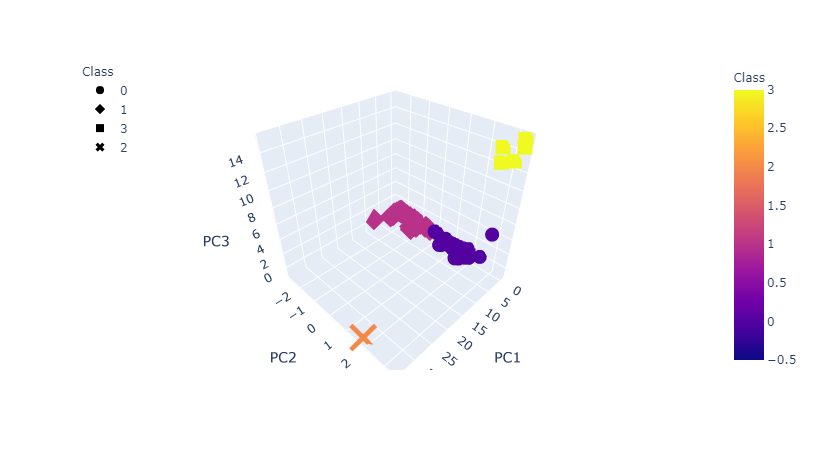

In [1268]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_df, x="PC1", y="PC2", z="PC3", color="Class", symbol="Class", width=800)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


#### Table of Tradable Cryptocurrencies

In [1269]:
# Table with tradable cryptos
clustered_df.hvplot.table(columns=clustered_df.columns.to_list(), sortable=True, selectable=True)


:Table   [Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class]

In [1270]:
# Print the total number of tradable cryptocurrencies
clustered_df.shape[0]


532

#### Scatter Plot with Tradable Cryptocurrencies

In [1277]:
# Scale data to create the scatter plot
clustered_df_plotting = clustered_df.loc[:, [ "TotalCoinsMined", "TotalCoinSupply" ]]
clustered_df_plotting = StandardScaler().fit_transform(clustered_df_plotting)
clustered_df["TotalCoinsMined_Scaled"] = clustered_df_plotting[:, 0]
clustered_df["TotalCoinSupply_Scaled"] = clustered_df_plotting[:, 1]
clustered_df.tail(20)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class,TotalCoinsMined_Scaled,TotalCoinSupply_Scaled
512,DPoS,DPoS,1.200121e+08,159918400,3.686876,1.614583,-0.168144,Lisk,0,-0.114476,-0.150507
513,Scrypt,PoS,1.000024e+10,10008835635,-0.093041,0.894098,-0.252252,HiCoin,0,0.102182,-0.004971
514,Scrypt,PoW/PoS,2.520056e+08,300000000,-0.329058,1.094732,-0.551169,WhiteCoin,0,-0.111582,-0.148437
515,NeoScrypt,PoW/PoS,1.120385e+06,60168145,-0.344298,0.494861,-0.289285,FriendshipCoin,0,-0.117084,-0.151981
516,Multiple,PoW,3.332922e+06,2800000,-0.132969,-1.869513,0.314046,JoinCoin,1,-0.117035,-0.152829
517,X13,PoW/PoS,1.407778e+05,120000,-0.277277,1.784413,-0.610768,Triangles Coin,0,-0.117105,-0.152869
518,Equihash+Scrypt,PoW,1.000000e+08,2100000000,-0.124012,-2.203088,0.480440,Vollar,1,-0.114915,-0.121839
519,DPoS,DPoS,1.020545e+09,0,3.696754,1.615071,-0.168438,EOS,0,-0.094729,-0.152870
520,Ethash,PoW,2.448794e+07,24487944,-0.149824,-2.055126,0.388229,Reality Clash,1,-0.116571,-0.152508
521,DPoS,DPoS,1.122382e+09,0,3.698000,1.615119,-0.168472,Oxycoin,0,-0.092496,-0.152870


In [1287]:
clustered_df["TotalCoinSupply"] = clustered_df["TotalCoinSupply"].astype(float)
clustered_df.dtypes

Algorithm                  object
ProofType                  object
TotalCoinsMined           float64
TotalCoinSupply           float64
PC1                       float64
PC2                       float64
PC3                       float64
CoinName                   object
Class                       int32
TotalCoinsMined_Scaled    float64
TotalCoinSupply_Scaled    float64
dtype: object

In [1297]:
# Compute y-axis scale
clustered_df["TotalCoinSupply"] = clustered_df["TotalCoinSupply"].astype(float)
ymin = clustered_df["TotalCoinSupply"].min()
ymax = clustered_df["TotalCoinSupply"].max()
num_yticks = 10
[ymin, ymax, num_yticks]

[0.0, 1000000000000.0, 10]

In [1298]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined", y="TotalCoinSupply", by="Class",
    logx=True,
    hover_cols=["CoinName"],
    height=400,
    yticks=[*range(int(ymin), int(ymax), int((ymax - ymin)/num_yticks))]
).opts(yformatter="%d")


:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)

In [1274]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined_Scaled", y="TotalCoinSupply_Scaled", by="Class",
    hover_cols=["CoinName"])


:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined_Scaled]   (TotalCoinSupply_Scaled,CoinName)